In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import itertools
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahmasleam/flowers-dataset")
path += '/flower_photos'

print("Path to dataset files:", path)

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resuming download from 11534336 bytes (218035311 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/rahmasleam/flowers-dataset?dataset_version_number=1 (11534336/229569647) bytes left.


100%|██████████| 219M/219M [00:03<00:00, 59.6MB/s] 

Extracting files...


Path to dataset files: /Users/zanderbonnet/.cache/kagglehub/datasets/rahmasleam/flowers-dataset/versions/1/flower_photos


In [3]:
folds = os.listdir(path)

filepaths = []
labels = []

for fold in folds:
    foldpath = os.path.join(path, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

files = pd.Series(filepaths, name= 'filepaths')
labels = pd.Series(labels, name='labels')

data = pd.concat([files, labels], axis= 1)
data

filepaths  labels
0     /Users/zanderbonnet/.cache/kagglehub/datasets/...   roses
1     /Users/zanderbonnet/.cache/kagglehub/datasets/...   roses
2     /Users/zanderbonnet/.cache/kagglehub/datasets/...   roses
3     /Users/zanderbonnet/.cache/kagglehub/datasets/...   roses
4     /Users/zanderbonnet/.cache/kagglehub/datasets/...   roses
...                                                 ...     ...
3665  /Users/zanderbonnet/.cache/kagglehub/datasets/...  tulips
3666  /Users/zanderbonnet/.cache/kagglehub/datasets/...  tulips
3667  /Users/zanderbonnet/.cache/kagglehub/datasets/...  tulips
3668  /Users/zanderbonnet/.cache/kagglehub/datasets/...  tulips
3669  /Users/zanderbonnet/.cache/kagglehub/datasets/...  tulips

[3670 rows x 2 columns]

In [4]:
train, test = train_test_split(data,  train_size = 0.8, random_state = 100, shuffle = True)
train, valid = train_test_split(train,  train_size = 0.8, random_state = 100, shuffle = True)

In [5]:
B_SIZE = 10
img_size = (224,224)

IG = ImageDataGenerator(rescale=1/255, horizontal_flip= True, vertical_flip= True, )

train_gen = IG.flow_from_dataframe(train, x_col = 'filepaths', y_col = 'labels', target_size= img_size,
                                        class_mode='categorical', color_mode='rgb',shuffle=True,
                                        batch_size=B_SIZE)

validation_gen = IG.flow_from_dataframe(valid, x_col = 'filepaths', y_col = 'labels', target_size= img_size,
                                        class_mode='categorical', color_mode='rgb',shuffle=True,
                                        batch_size=B_SIZE)

test_gen = IG.flow_from_dataframe(test, x_col = 'filepaths', y_col = 'labels', target_size= img_size,
                                        class_mode='categorical', color_mode='rgb',shuffle=True,
                                        batch_size=B_SIZE)

Found 2348 validated image filenames belonging to 5 classes.
Found 588 validated image filenames belonging to 5 classes.
Found 734 validated image filenames belonging to 5 classes.


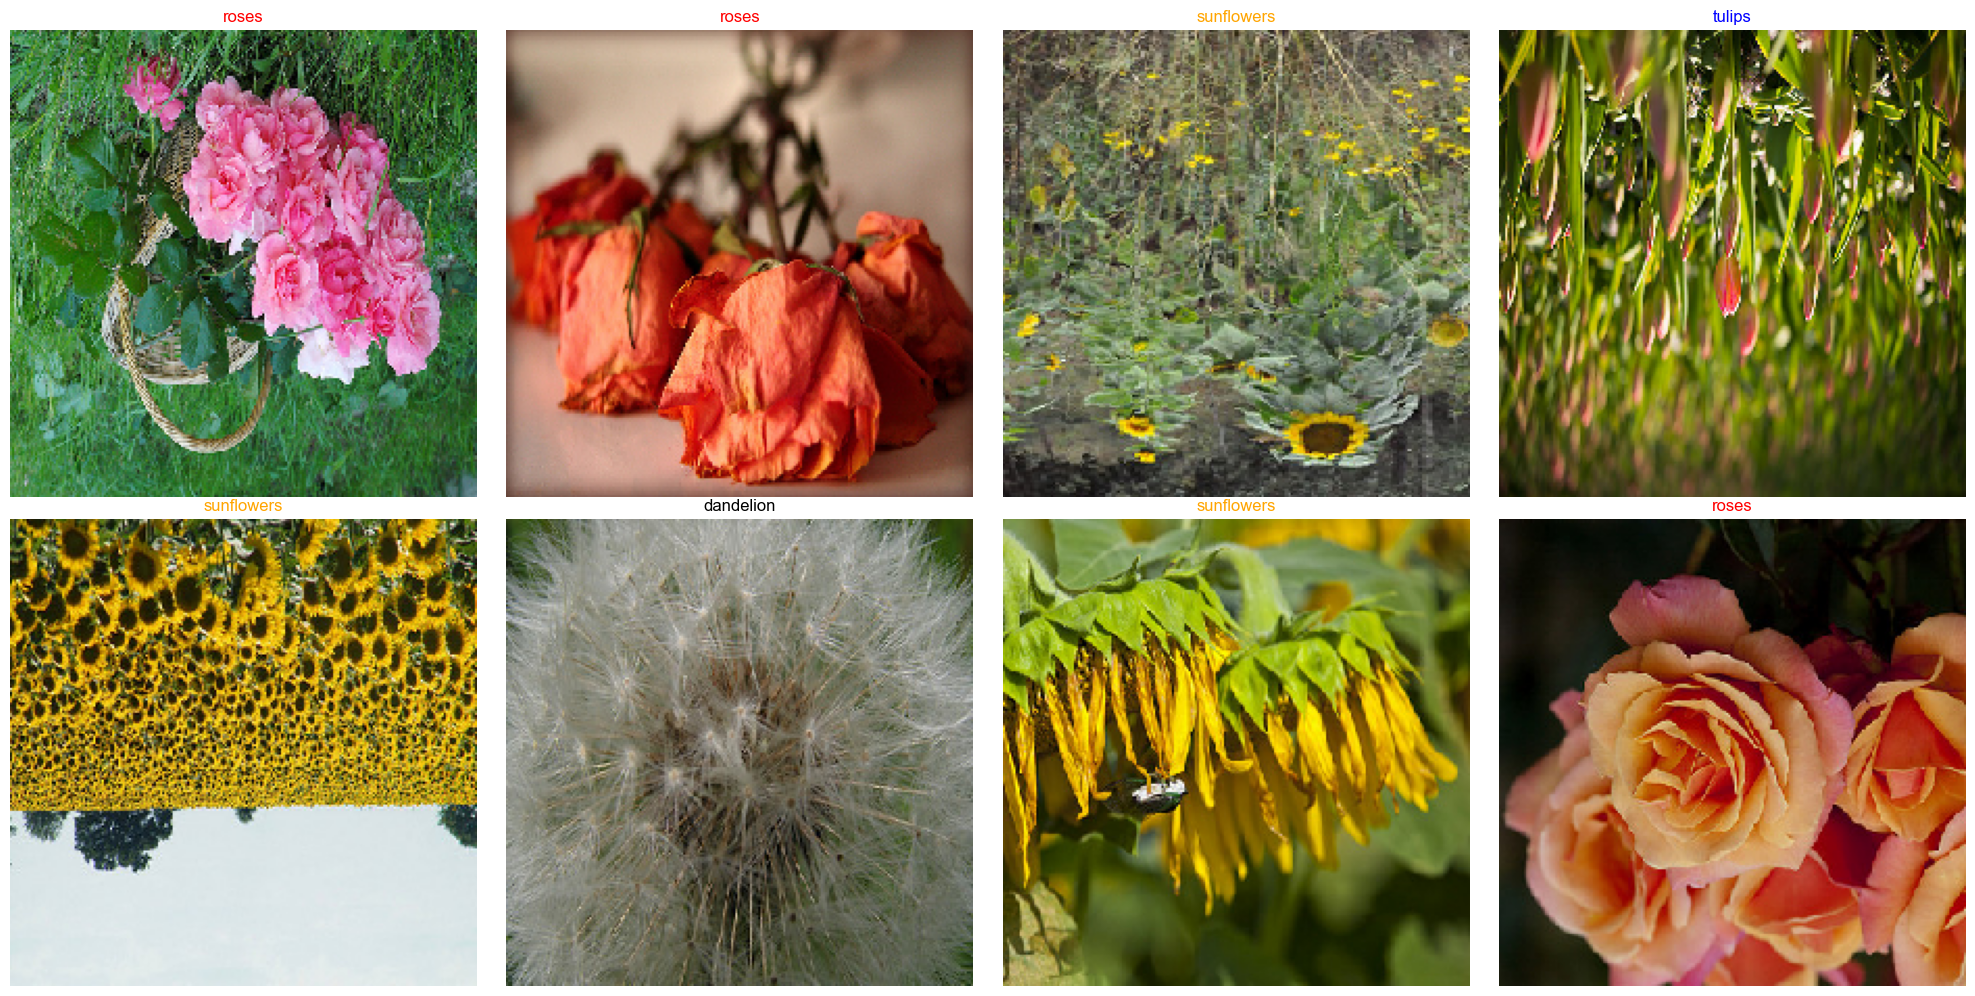

In [6]:
g_dict = train_gen.class_indices 
classes = list(g_dict.keys()) 
images, labels = next(train_gen) 

plt.figure(figsize= (20, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    if class_name == 'sunflowers':
        plt.title(class_name, color = 'orange')
    if class_name == 'dandelion':
        plt.title(class_name, color = 'black')
    if class_name == 'roses':
        plt.title(class_name, color = 'red')
    if class_name == 'tulips':
        plt.title(class_name, color = 'blue')
    if class_name == 'daisy':
        plt.title(class_name, color = 'green')
    plt.axis('off')    
plt.tight_layout()
plt.show()

In [7]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')  
])

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,457,509 (9.37 MB)

 Trainable params: 2,457,509 (9.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
opt = optimizers.Nadam()
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
hist = model.fit(train_gen, 
                epochs = 50,
                validation_data = validation_gen,
                callbacks=[stop])

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.3958 - loss: 1.4045 - val_accuracy: 0.5408 - val_loss: 1.1456
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5802 - loss: 1.0474 - val_accuracy: 0.6276 - val_loss: 0.9339
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.6354 - loss: 0.9213 - val_accuracy: 0.6888 - val_loss: 0.8286
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6714 - loss: 0.8584 - val_accuracy: 0.6837 - val_loss: 0.8306
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6842 - loss: 0.8319 - val_accuracy: 0.6871 - val_loss: 0.8475
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6840 - loss: 0.7781 - val_accuracy: 0.6803 - val_loss: 0.8519
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.7248 - loss: 0.6973 - val_accuracy: 0.6956 - val_loss: 0.8095
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.7413 - loss: 0.6661 - 

In [11]:
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(validation_gen)
test_score = model.evaluate(test_gen)

235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8848 - loss: 0.3161
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7274 - loss: 0.7890
 9/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7812 - loss: 0.5705

/Users/zanderbonnet/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7255 - loss: 0.7620


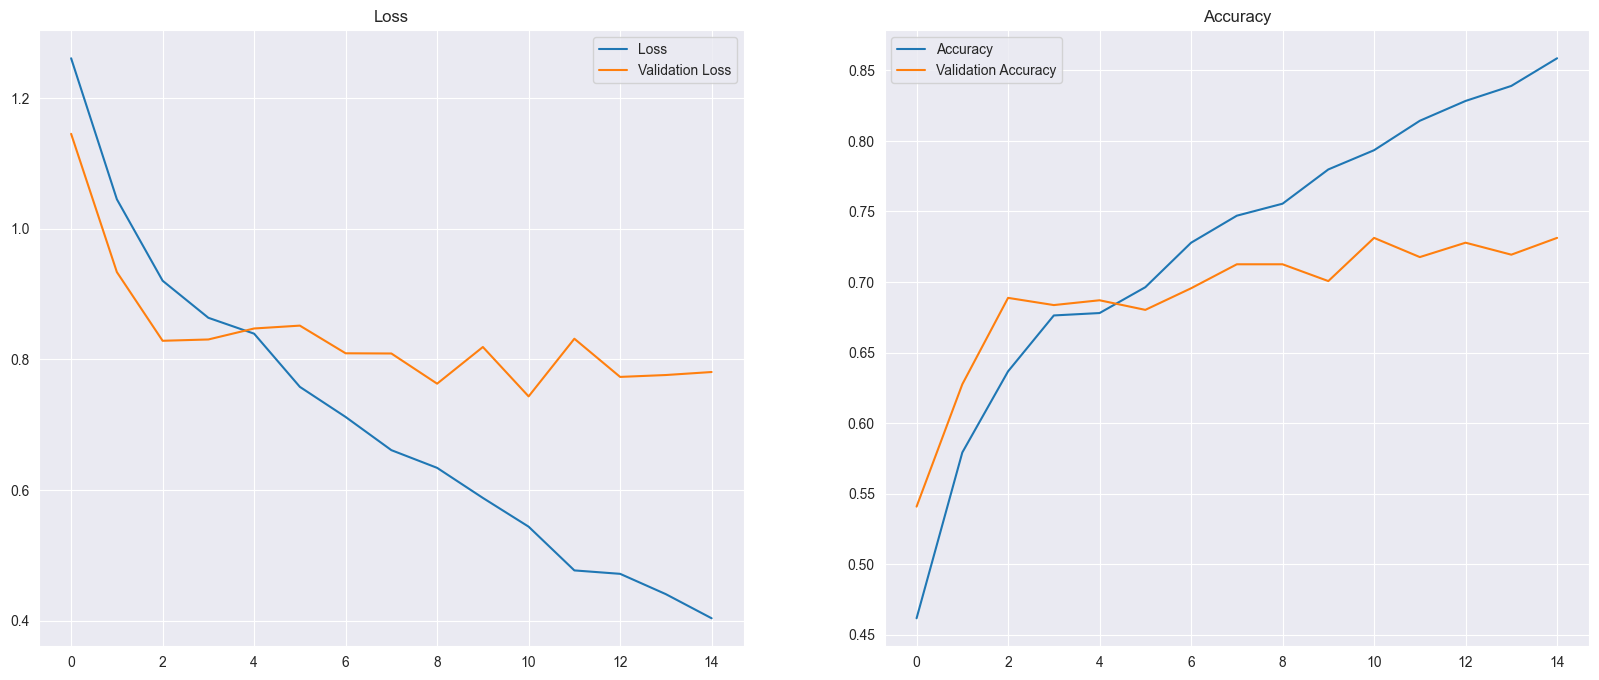

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set(title = 'Loss')
ax[0].plot(hist.history['loss'], label = 'Loss')
ax[0].plot(hist.history['val_loss'], label = 'Validation Loss')
ax[0].legend()

ax[1].set(title = 'Accuracy')
ax[1].plot(hist.history['accuracy'], label = 'Accuracy')
ax[1].plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
ax[1].legend()
plt.show()

In [13]:
preds = model.predict(test_gen)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [14]:
y_preds = np.argmax(preds,axis = 1)

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
g_dict

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [16]:
conf = confusion_matrix(test_gen.classes, y_preds)

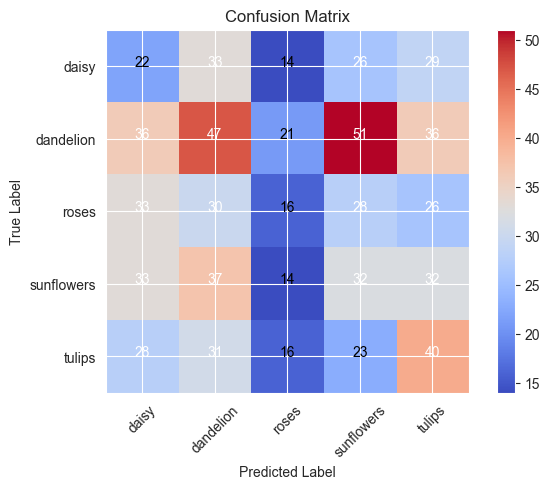

In [17]:
plt.imshow(conf, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, conf[i, j], horizontalalignment= 'center', color= 'white' if conf[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()
plt.show()

In [18]:
print(classification_report(test_gen.classes, y_preds, target_names= classes))

              precision    recall  f1-score   support

       daisy       0.14      0.18      0.16       124
   dandelion       0.26      0.25      0.25       191
       roses       0.20      0.12      0.15       133
  sunflowers       0.20      0.22      0.21       148
      tulips       0.25      0.29      0.27       138

    accuracy                           0.21       734
   macro avg       0.21      0.21      0.21       734
weighted avg       0.22      0.21      0.21       734

